# **Description**







The evolution of wireless communications is expected to rely on machine learning (ML)-based capabilities to provide proactive management of network resources and sustain quality-of-service (QoS) and user experience. New use cases in the area of vehicular communications, including so-called vehicle-to-everything (V2X) schemes, will benefit strongly from such advances.

The objective of this challenge is to leverage the Berlin V2X dataset to predict QoS. More specifically, several features from the primary and secondary cells of two commercial LTE mobile network operators in the metropolitan area of Berlin can be used alongside GPS and context information to predict the achieved throughput in the downlink.

The results of this challenge will serve as a cornerstone to deploy general solutions for wireless QoS prediction in a multi-domain setup (i.e., across operators, devices and/or link directions).



In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/MyDrive/itu-ffs')  # Fix This if your file is in a Certain Directory in Your Drive

Mounted at /content/drive/


In [2]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

# Data loading

The data includes information on:

Physical layer parameters (such as signal strength and signal quality).
Cellular radio resource management like cell identity, modulation and coding scheme, assigned resource blocks, and carrier aggregation (i.e., primary/secondary cell data).
Wireless Quality-of-Service (QoS) in the form of downlink throughput.
GPS-positioning information.
Side information (traffic and weather).

In [3]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
sample_submission = pd.read_csv('SampleSubmission.csv')

In [4]:
def timestamp_to_date(timestamp):
    return pd.to_datetime(timestamp, unit='s')

train_df['timestamp'] = train_df['timestamp'].apply(timestamp_to_date)
test_df['timestamp'] = test_df['timestamp'].apply(timestamp_to_date)

def separate_date(df):
    df['minute'] = df['timestamp'].dt.minute
    df['second'] = df['timestamp'].dt.second
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
    return df

train_df = separate_date(train_df)
test_df = separate_date(test_df)

train_df['timestamp'].min() , train_df['timestamp'].max() , (train_df['timestamp'].max() -train_df['timestamp'].min())

(Timestamp('2021-06-22 07:49:54'),
 Timestamp('2021-06-24 16:59:59'),
 Timedelta('2 days 09:10:05'))

In [5]:
test_df['timestamp'].min() , test_df['timestamp'].max() , (test_df['timestamp'].max() -test_df['timestamp'].min())

(Timestamp('2021-06-22 07:49:54'),
 Timestamp('2021-06-22 16:13:59'),
 Timedelta('0 days 08:24:05'))

In [6]:
train_df.sort_values('timestamp', inplace=True)

In [7]:
test_df.sort_values('timestamp', inplace=True)

In [8]:
train_df

,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,visibility,Traffic Jam Factor,area,target,minute,second,year,month,day,hour
3212,Id_gcx07pcxf1,2021-06-22 07:49:54,pc1,-76.638750,-14.119375,-45.562500,22.090000,29914.0,26.0,20.0,...,16.093,3.44075,Avenue,68700000.0,49,54,2021,6,22,7
16297,Id_nz10z33hu6,2021-06-22 07:49:54,pc3,-97.028125,-12.309375,-63.323125,10.339000,43804.0,23.0,20.0,...,16.093,2.53146,Avenue,49800000.0,49,54,2021,6,22,7
30228,Id_ubdj0txwhp,2021-06-22 07:49:55,pc3,-96.546875,-12.516875,-62.695625,8.755000,47308.0,20.0,20.0,...,16.093,2.53146,Avenue,49700000.0,49,55,2021,6,22,7
5146,Id_oggztixnf9,2021-06-22 07:49:55,pc1,-77.602500,-14.550000,-45.241250,22.183000,36796.0,25.0,20.0,...,16.093,3.44075,Avenue,80300000.0,49,55,2021,6,22,7
8506,Id_50jxj5mht8,2021-06-22 07:49:56,pc1,-77.634375,-14.661875,-45.315625,22.364000,27210.0,24.0,20.0,...,16.093,3.44075,Avenue,82600000.0,49,56,2021,6,22,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9173,Id_zwzpvb8e2z,2021-06-24 16:59:55,pc1,-79.468125,-15.093125,-44.281875,17.688000,59124.0,25.0,20.0,...,16.093,2.34287,Avenue,178000000.0,59,55,2021,6,24,16
10410,Id_dsesbji4qr,2021-06-24 16:59:56,pc1,-79.613750,-14.644375,-44.915625,16.625000,46510.0,26.0,20.0,...,16.093,2.34287,Avenue,178000000.0,59,56,2021,6,24,16
23016,Id_o5miz2v2z5,2021-06-24 16:59:57,pc1,-79.853750,-14.766875,-45.041875,16.368000,47329.0,25.0,20.0,...,16.093,2.34287,Avenue,165000000.0,59,57,2021,6,24,16
19743,Id_72x7xai1jo,2021-06-24 16:59:58,pc1,-80.072331,-15.554775,-44.412921,15.761798,76130.0,26.0,20.0,...,16.093,2.34287,Avenue,177000000.0,59,58,2021,6,24,16


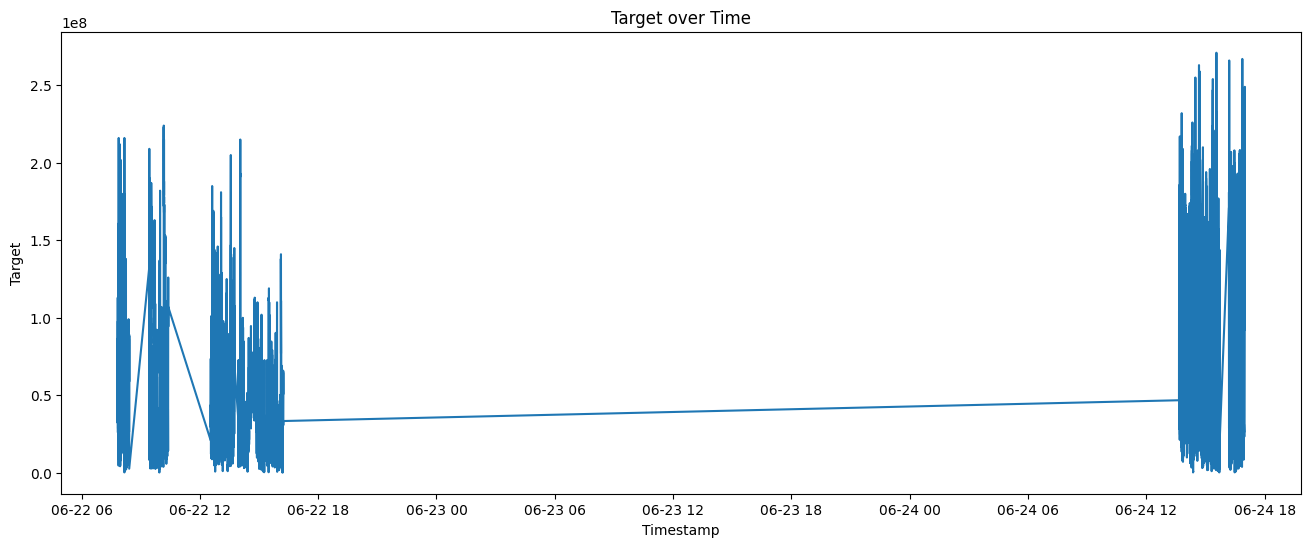

In [9]:
import matplotlib.pyplot as plt
# Step 3: Plot the target variable over time
plt.figure(figsize=(16, 6))
plt.plot(train_df['timestamp'], train_df['target'])
plt.xlabel('Timestamp')
plt.ylabel('Target')
plt.title('Target over Time')
plt.show()

# Data preparation

Checking for 'null' values , and Count missing values in each column

In [10]:
train_df.isna().sum()

id                                  0
timestamp                           0
device                              0
PCell_RSRP_max                      0
PCell_RSRQ_max                      0
PCell_RSSI_max                      0
PCell_SNR_max                       0
PCell_Downlink_Num_RBs              0
PCell_Downlink_Average_MCS          0
PCell_Downlink_bandwidth_MHz     1067
PCell_Cell_Identity              1067
PCell_freq_MHz                      0
SCell_RSRP_max                  15262
SCell_RSRQ_max                  15262
SCell_RSSI_max                  15262
SCell_SNR_max                   15262
SCell_Downlink_Num_RBs          15939
SCell_Downlink_Average_MCS      15939
SCell_Downlink_bandwidth_MHz    20849
SCell_Cell_Identity             20849
SCell_freq_MHz                  15262
operator                            0
Latitude                            0
Longitude                           0
Altitude                            7
speed_kmh                           0
COG         

In [11]:
test_df.isna().sum()

id                                  0
timestamp                           0
device                              0
PCell_RSRP_max                      0
PCell_RSRQ_max                      0
PCell_RSSI_max                      0
PCell_SNR_max                       0
PCell_Downlink_Num_RBs              1
PCell_Downlink_Average_MCS          1
PCell_Downlink_bandwidth_MHz        0
PCell_Cell_Identity                 0
PCell_freq_MHz                      0
SCell_RSRP_max                   8615
SCell_RSRQ_max                   8615
SCell_RSSI_max                   8615
SCell_SNR_max                    8615
SCell_Downlink_Num_RBs           9350
SCell_Downlink_Average_MCS       9350
SCell_Downlink_bandwidth_MHz    13383
SCell_Cell_Identity             13383
SCell_freq_MHz                   8615
operator                            0
Latitude                            0
Longitude                           0
Altitude                            5
speed_kmh                           0
COG         

In [12]:
train_df.describe()

,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz,SCell_RSRP_max,...,uvIndex,visibility,Traffic Jam Factor,target,minute,second,year,month,day,hour
count,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,33207.000000,3.320700e+04,34274.000000,19012.000000,...,34274.000000,3.427400e+04,33946.000000,3.427400e+04,34274.000000,34274.000000,34274.0,34274.0,34274.000000,34274.000000
mean,-87.085767,-13.061258,-54.435712,11.861843,64089.078835,19.973858,19.233746,1.898801e+07,1926.737469,-89.184523,...,2.564072,1.609300e+01,3.328803,5.550386e+07,29.376408,29.596750,2021.0,6.0,22.894672,13.249635
std,11.719533,2.463729,10.765029,7.414607,22991.689616,5.054947,1.898843,1.381858e+07,264.412295,9.508438,...,1.023344,3.552766e-15,2.202747,4.319385e+07,17.395258,17.316173,0.0,0.0,0.994452,2.656378
min,-175.605625,-24.774375,-87.852500,-15.603000,4.000000,0.000000,5.000000,2.567188e+06,900.000000,-174.971875,...,1.000000,1.609300e+01,0.000000,4.800000e+04,0.000000,0.000000,2021.0,6.0,22.000000,7.000000
25%,-95.201562,-14.790000,-61.961719,6.431250,43724.000000,17.000000,20.000000,3.282957e+06,1800.000000,-95.137751,...,2.000000,1.609300e+01,2.171180,2.400000e+07,14.000000,15.000000,2021.0,6.0,22.000000,12.000000
50%,-86.845313,-12.681875,-53.992500,12.171000,62785.000000,21.000000,20.000000,2.635878e+07,1800.000000,-89.544688,...,3.000000,1.609300e+01,3.009460,4.240000e+07,29.000000,30.000000,2021.0,6.0,22.000000,14.000000
75%,-79.246719,-11.378252,-46.845156,17.579000,87828.000000,24.000000,20.000000,2.694707e+07,2000.000000,-82.386215,...,3.000000,1.609300e+01,3.454510,7.200000e+07,44.000000,45.000000,2021.0,6.0,24.000000,15.000000
max,-55.550625,-5.389375,-13.032500,28.622000,100471.000000,28.000000,20.000000,5.184258e+07,2600.000000,-55.193125,...,4.000000,1.609300e+01,9.602590,2.710000e+08,59.000000,59.000000,2021.0,6.0,24.000000,16.000000


<ipython-input-13-7e9940fd9a34>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(),annot=True)


<Axes: >

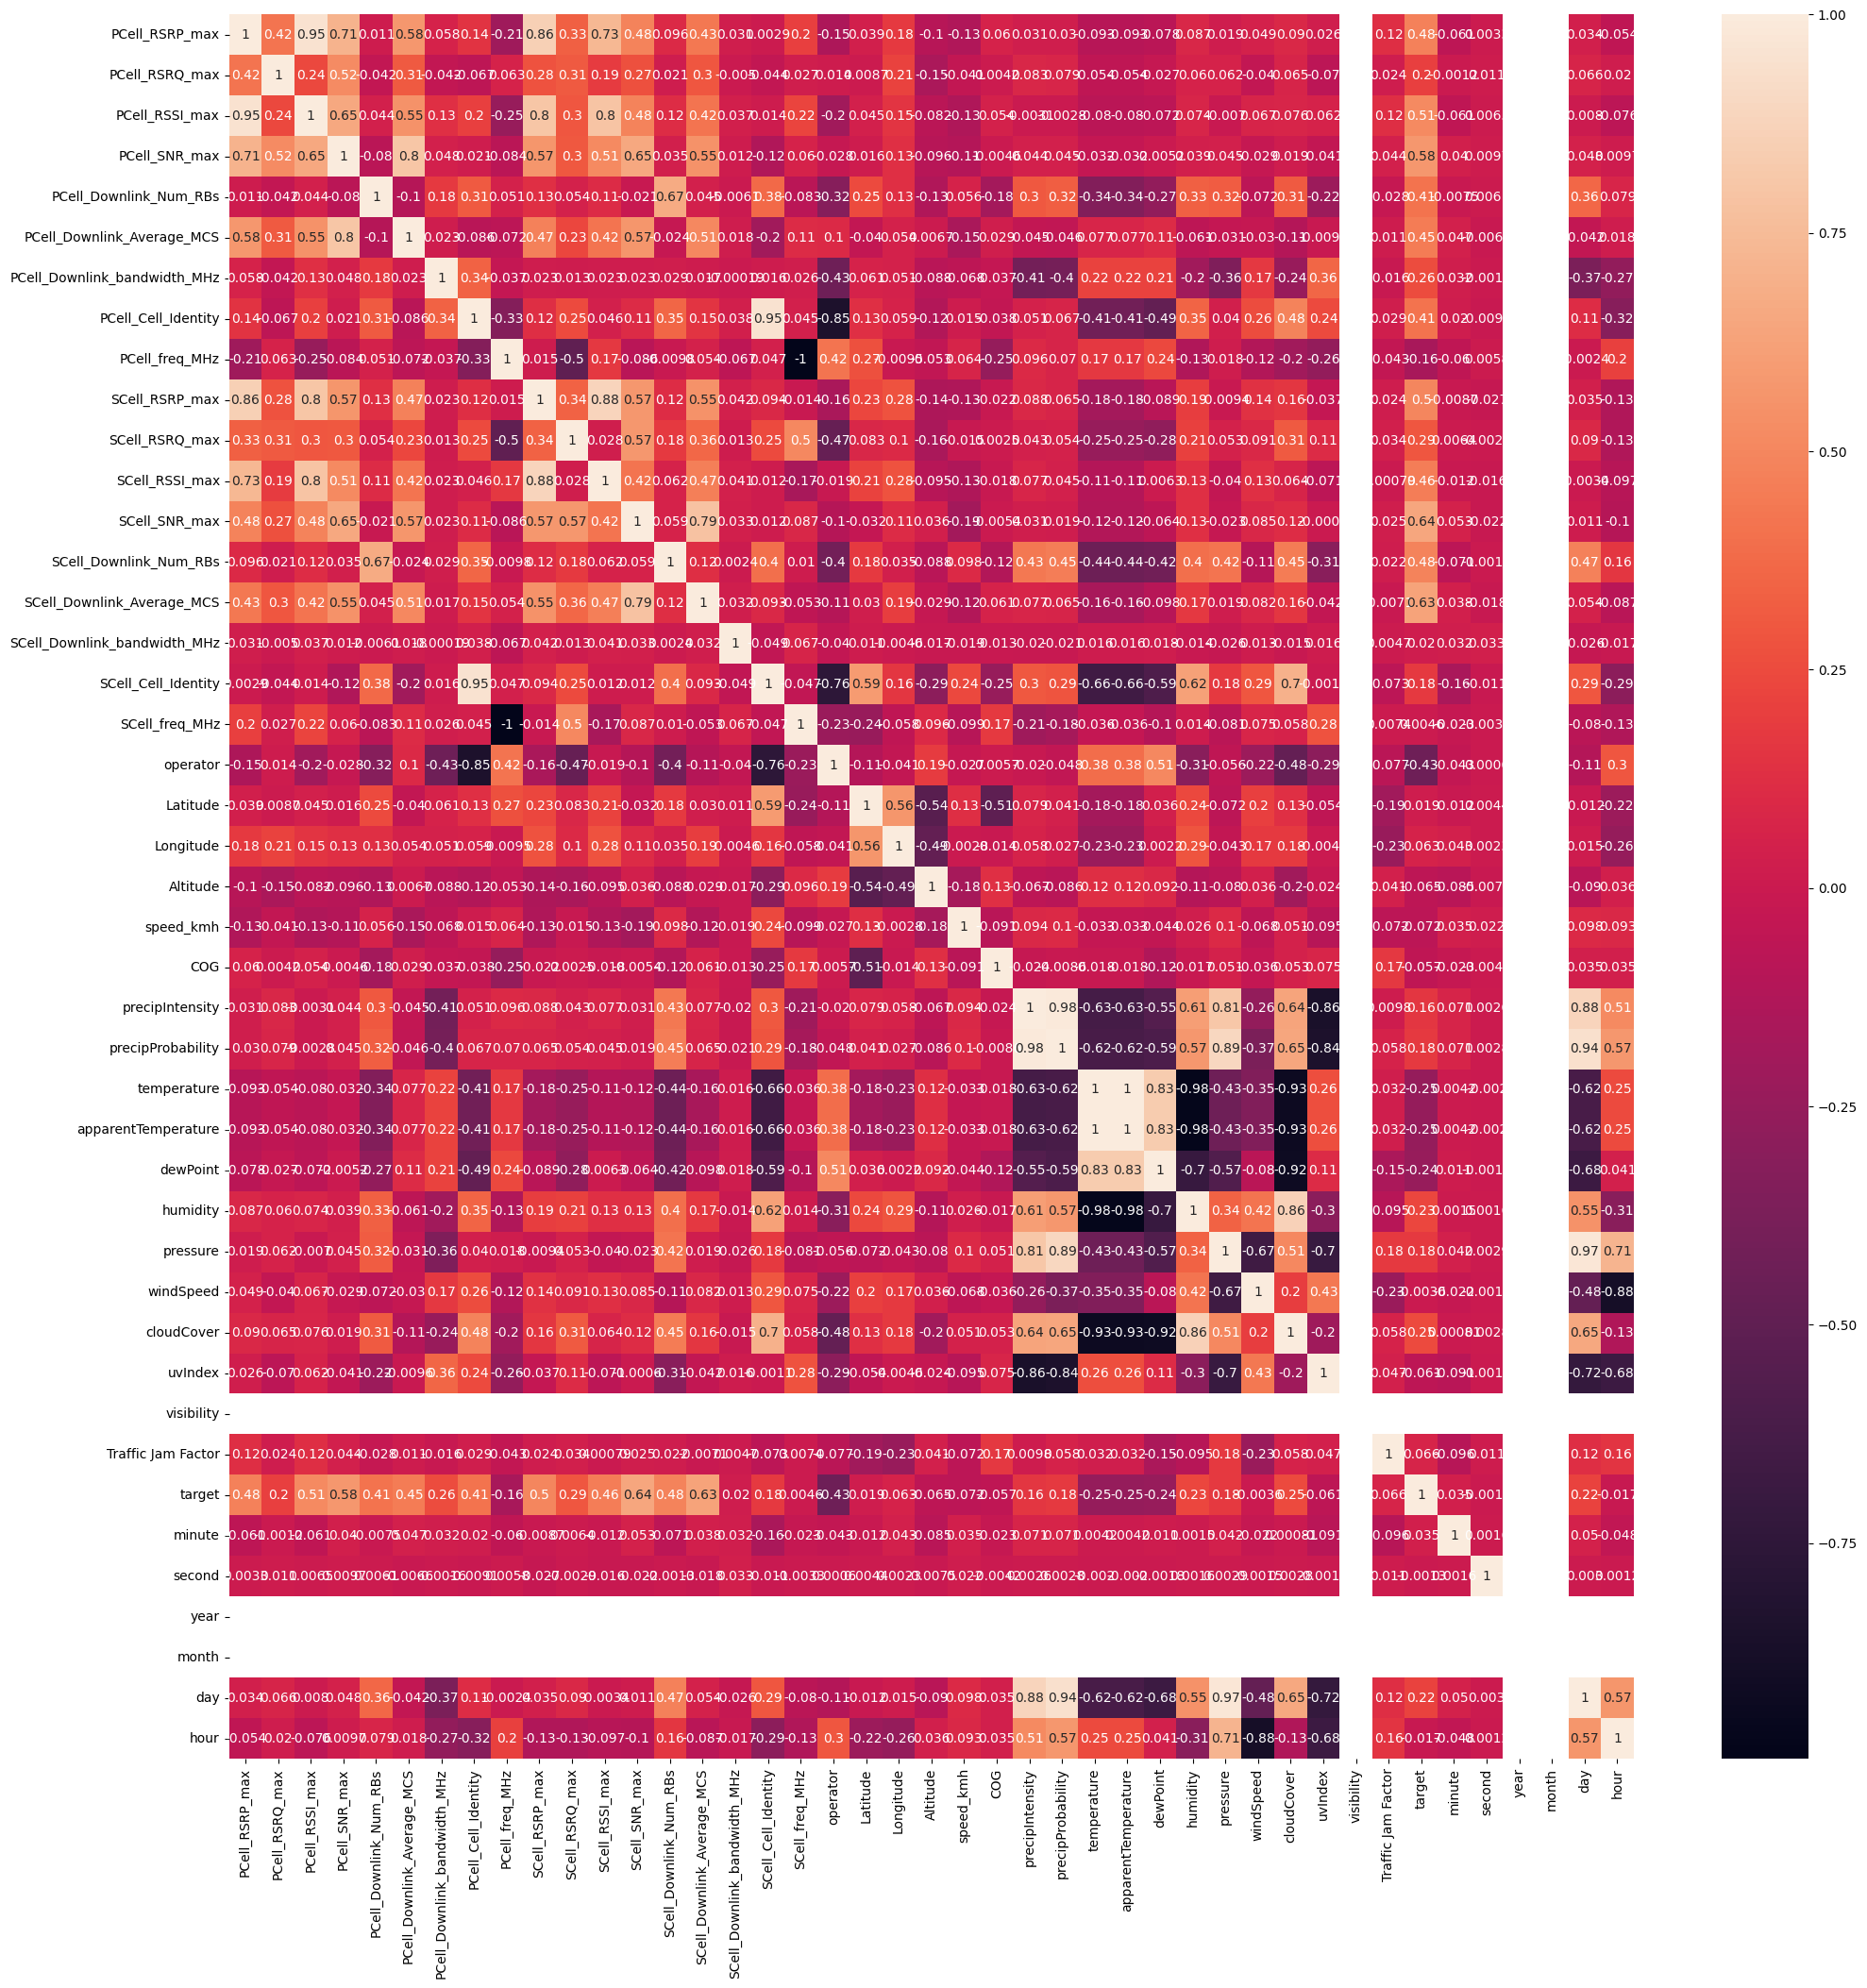

In [13]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (24,24))
sns.heatmap(train_df.corr(),annot=True)

In [14]:
# Step 4: Apply lagged variables
lagged_features = ['PCell_RSRP_max','PCell_RSRQ_max' ,'PCell_RSSI_max','PCell_SNR_max' ,'PCell_Downlink_Num_RBs',
                   'PCell_Downlink_Average_MCS','PCell_Downlink_bandwidth_MHz','PCell_Cell_Identity','PCell_freq_MHz','SCell_RSRP_max','SCell_RSRQ_max','SCell_RSSI_max',
                   'SCell_SNR_max','SCell_Downlink_Num_RBs','SCell_Downlink_Average_MCS','SCell_Downlink_bandwidth_MHz','SCell_Cell_Identity','SCell_freq_MHz','precipIntensity','precipProbability','temperature','apparentTemperature','dewPoint','humidity','pressure','windSpeed',
                   'cloudCover','uvIndex']  # Specify the lagged features

lags = [1,2]  # Specify the lag periods


for feature in lagged_features:
    for lag in lags:
        train_df[f'{feature}_lag{lag}'] = train_df[feature].shift(lag)
        test_df[f'{feature}_lag{lag}'] = test_df[feature].shift(lag)


In [15]:
'''
from itertools import combinations
# Step 4: Apply lagged variables
lagged_features = ['PCell_RSRP_max','PCell_RSRQ_max' ,'PCell_RSSI_max','PCell_SNR_max' ,'PCell_Downlink_Num_RBs']  # Specify the lagged features


lags = [1]  # Specify the lag periods
# Create combinations of lagged features
lagged_feature_combinations = []
for r in range(1, len(lagged_features) + 1):
    lagged_feature_combinations.extend(combinations(lagged_features, r))

for combination in lagged_feature_combinations:
    for lag in lags:
        lagged_feature_name = '_'.join(combination) + f'_lag{lag}'
        train_df[lagged_feature_name] = train_df[list(combination)].shift(lag).mean(axis=1)
        test_df[lagged_feature_name] = test_df[list(combination)].shift(lag).mean(axis=1)
'''

"\nfrom itertools import combinations\n# Step 4: Apply lagged variables\nlagged_features = ['PCell_RSRP_max','PCell_RSRQ_max' ,'PCell_RSSI_max','PCell_SNR_max' ,'PCell_Downlink_Num_RBs']  # Specify the lagged features\n\n\nlags = [1]  # Specify the lag periods\n# Create combinations of lagged features\nlagged_feature_combinations = []\nfor r in range(1, len(lagged_features) + 1):\n    lagged_feature_combinations.extend(combinations(lagged_features, r))\n\nfor combination in lagged_feature_combinations:\n    for lag in lags:\n        lagged_feature_name = '_'.join(combination) + f'_lag{lag}'\n        train_df[lagged_feature_name] = train_df[list(combination)].shift(lag).mean(axis=1)\n        test_df[lagged_feature_name] = test_df[list(combination)].shift(lag).mean(axis=1)\n"

In [16]:
# Split inputs and targets
train_inputs = train_df.drop(columns=['target'])
train_targets = train_df['target']
test_inputs = test_df.copy()

In [17]:
# Select features
dropped_columns = ['device', 'id','visibility','timestamp' ,'year','month']
train_inputs.drop(columns=dropped_columns, inplace=True)
test_inputs.drop(columns=dropped_columns, inplace=True)

In [18]:
train_inputs.describe()

,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz,SCell_RSRP_max,...,humidity_lag1,humidity_lag2,pressure_lag1,pressure_lag2,windSpeed_lag1,windSpeed_lag2,cloudCover_lag1,cloudCover_lag2,uvIndex_lag1,uvIndex_lag2
count,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,33207.000000,3.320700e+04,34274.000000,19012.000000,...,34273.000000,34272.000000,34273.000000,34272.000000,34273.000000,34272.000000,34273.000000,34272.000000,34273.000000,34272.000000
mean,-87.085767,-13.061258,-54.435712,11.861843,64089.078835,19.973858,19.233746,1.898801e+07,1926.737469,-89.184523,...,0.682185,0.682183,1015.186345,1015.186280,2.613570,2.613576,0.938073,0.938072,2.564118,2.564163
std,11.719533,2.463729,10.765029,7.414607,22991.689616,5.054947,1.898843,1.381858e+07,264.412295,9.508438,...,0.063657,0.063657,2.377353,2.377358,0.756249,0.756259,0.078150,0.078150,1.023324,1.023304
min,-175.605625,-24.774375,-87.852500,-15.603000,4.000000,0.000000,5.000000,2.567188e+06,900.000000,-174.971875,...,0.550000,0.550000,1011.900000,1011.900000,1.960000,1.960000,0.760000,0.760000,1.000000,1.000000
25%,-95.201562,-14.790000,-61.961719,6.431250,43724.000000,17.000000,20.000000,3.282957e+06,1800.000000,-95.137751,...,0.620000,0.620000,1013.500000,1013.500000,2.160000,2.160000,0.940000,0.940000,2.000000,2.000000
50%,-86.845313,-12.681875,-53.992500,12.171000,62785.000000,21.000000,20.000000,2.635878e+07,1800.000000,-89.544688,...,0.710000,0.710000,1013.800000,1013.800000,2.290000,2.290000,0.970000,0.970000,3.000000,3.000000
75%,-79.246719,-11.378252,-46.845156,17.579000,87828.000000,24.000000,20.000000,2.694707e+07,2000.000000,-82.386215,...,0.730000,0.730000,1017.700000,1017.700000,2.430000,2.430000,0.990000,0.990000,3.000000,3.000000
max,-55.550625,-5.389375,-13.032500,28.622000,100471.000000,28.000000,20.000000,5.184258e+07,2600.000000,-55.193125,...,0.770000,0.770000,1018.000000,1018.000000,4.250000,4.250000,1.000000,1.000000,4.000000,4.000000


In [19]:
train_inputs.corr()

<ipython-input-19-dfb3895cff00>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_inputs.corr()


,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz,SCell_RSRP_max,...,humidity_lag1,humidity_lag2,pressure_lag1,pressure_lag2,windSpeed_lag1,windSpeed_lag2,cloudCover_lag1,cloudCover_lag2,uvIndex_lag1,uvIndex_lag2
PCell_RSRP_max,1.000000,0.418942,0.948991,0.705462,0.011121,0.575683,0.057875,0.144798,-0.207848,0.857836,...,0.087015,0.087112,0.018839,0.018767,0.049008,0.049090,0.090037,0.090031,0.025750,0.025716
PCell_RSRQ_max,0.418942,1.000000,0.237134,0.521783,-0.042198,0.308165,-0.041698,-0.066630,0.063469,0.280625,...,0.060185,0.060181,0.062019,0.062088,-0.039739,-0.039829,0.065032,0.065013,-0.069959,-0.070065
PCell_RSSI_max,0.948991,0.237134,1.000000,0.650101,0.044471,0.554136,0.131258,0.199501,-0.247746,0.797539,...,0.073765,0.073860,-0.007044,-0.007132,0.066886,0.066985,0.076015,0.076012,0.061487,0.061484
PCell_SNR_max,0.705462,0.521783,0.650101,1.000000,-0.080110,0.802788,0.047716,0.021409,-0.083533,0.567598,...,0.038812,0.038802,0.045078,0.045067,-0.029068,-0.029117,0.018676,0.018684,-0.041350,-0.041321
PCell_Downlink_Num_RBs,0.011121,-0.042198,0.044471,-0.080110,1.000000,-0.101364,0.179927,0.306230,0.051489,0.128867,...,0.334837,0.334790,0.321164,0.321070,-0.071520,-0.071493,0.309978,0.309840,-0.219478,-0.219567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
windSpeed_lag2,0.049090,-0.039829,0.066985,-0.029117,-0.071493,-0.029766,0.165608,0.257361,-0.117187,0.136595,...,0.415700,0.415883,-0.665925,-0.665929,0.999923,1.000000,0.195611,0.195653,0.432768,0.432678
cloudCover_lag1,0.090037,0.065032,0.076015,0.018676,0.309978,-0.108600,-0.235892,0.480057,-0.196332,0.160573,...,0.859724,0.859644,0.506344,0.506339,0.195644,0.195611,1.000000,0.999799,-0.201372,-0.201481
cloudCover_lag2,0.090031,0.065013,0.076012,0.018684,0.309840,-0.108577,-0.235855,0.480008,-0.196291,0.160633,...,0.859591,0.859721,0.506231,0.506334,0.195662,0.195653,0.999799,1.000000,-0.201406,-0.201345
uvIndex_lag1,0.025750,-0.069959,0.061487,-0.041350,-0.219478,-0.009551,0.358950,0.243708,-0.260219,-0.036846,...,-0.298845,-0.298780,-0.697966,-0.698018,0.432675,0.432768,-0.201372,-0.201406,1.000000,0.999916


In [20]:
# Transform categorical features
categorical_features = ['area']
oe = OrdinalEncoder()
train_inputs[categorical_features] = oe.fit_transform(train_inputs[categorical_features])
test_inputs[categorical_features] = oe.transform(test_inputs[categorical_features])

# Missing value imputation
#train_inputs.fillna(train_inputs.mean(), inplace=True)
#test_inputs.fillna(test_inputs.mean(), inplace=True)

train_inputs.fillna(0, inplace=True)
test_inputs.fillna(0, inplace=True)

train_inputs.isna().sum()

PCell_RSRP_max            0
PCell_RSRQ_max            0
PCell_RSSI_max            0
PCell_SNR_max             0
PCell_Downlink_Num_RBs    0
                         ..
windSpeed_lag2            0
cloudCover_lag1           0
cloudCover_lag2           0
uvIndex_lag1              0
uvIndex_lag2              0
Length: 96, dtype: int64

In [21]:
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV

In [22]:

# Split training and validation tests

X_train, X_test, y_train, y_test = train_test_split(train_inputs, train_targets, test_size = 0.2, random_state = 0)

# Feature Scaling
#sc = StandardScaler()
#x_train = sc.fit_transform(X_train)
#x_test= sc.transform(X_test)

x_train=X_train
x_test=X_test

# Prediction algorithm

In [23]:
# Create algorithm
rf = RandomForestRegressor()
#Fit the Model to Training Set
# Train
rf.fit(x_train, y_train)
# Validation
val_predictions_rf = rf.predict(x_test)
# Test
test_predictions_rf = rf.predict(test_inputs)
#Compute error metric
rmse_rf = mean_squared_error(y_test, val_predictions_rf, squared=False)
print(f"Root Mean Squared Error = {rmse_rf / 1e6:.3} Mbit/s")

Root Mean Squared Error = 9.29 Mbit/s


In [24]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


In [25]:
from catboost import CatBoostRegressor
# Create algorithm
cbr = CatBoostRegressor(loss_function = "RMSE", iterations=2000)
#Fit the Model to Training Set
# Train
cbr.fit(x_train, y_train)
# Validation
val_predictions_cbr = cbr.predict(x_test)
# Test
test_predictions_cbr = cbr.predict(test_inputs)
#Compute error metric
rmse_cbr = mean_squared_error(y_test, val_predictions_cbr, squared=False)
print(f"Root Mean Squared Error = {rmse_cbr / 1e6:.3} Mbit/s")

Learning rate set to 0.039324
0:	learn: 41754528.0972854	total: 74.9ms	remaining: 2m 29s
1:	learn: 40514624.7057359	total: 99.6ms	remaining: 1m 39s
2:	learn: 39308526.2034415	total: 123ms	remaining: 1m 21s
3:	learn: 38144090.6606288	total: 145ms	remaining: 1m 12s
4:	learn: 37032357.4777468	total: 172ms	remaining: 1m 8s
5:	learn: 36010567.9021317	total: 194ms	remaining: 1m 4s
6:	learn: 34996228.4821852	total: 217ms	remaining: 1m 1s
7:	learn: 34049295.1053845	total: 240ms	remaining: 59.9s
8:	learn: 33123630.6187983	total: 263ms	remaining: 58.2s
9:	learn: 32243538.8266090	total: 293ms	remaining: 58.2s
10:	learn: 31378383.0808562	total: 320ms	remaining: 57.9s
11:	learn: 30575753.3818416	total: 343ms	remaining: 56.9s
12:	learn: 29795465.7707015	total: 367ms	remaining: 56.1s
13:	learn: 29047309.0706448	total: 388ms	remaining: 55.1s
14:	learn: 28319629.0773270	total: 412ms	remaining: 54.5s
15:	learn: 27645503.1531096	total: 434ms	remaining: 53.8s
16:	learn: 26985615.7675196	total: 457ms	remai

In [26]:
import xgboost as xgb
# Create algorithm
xg = xgb.XGBRegressor()
#Fit the Model to Training Set
# Train
xg.fit(x_train, y_train)
# Validation
val_predictions_xg = xg.predict(x_test)
# Test
test_predictions_xg = xg.predict(test_inputs)
#Compute error metric
rmse_xg = mean_squared_error(y_test, val_predictions_xg, squared=False)
print(f"Root Mean Squared Error = {rmse_xg / 1e6:.3} Mbit/s")

Root Mean Squared Error = 8.98 Mbit/s


In [27]:
from sklearn.ensemble import AdaBoostRegressor
ar = AdaBoostRegressor()
# Train
ar.fit(x_train, y_train)
# Validation
val_predictions_ar = ar.predict(x_test)
# Test
test_predictions_ar = ar.predict(test_inputs)
#Compute error metric
rmse_ar = mean_squared_error(y_test, val_predictions_ar, squared=False)
print(f"Root Mean Squared Error = {rmse_ar / 1e6:.3} Mbit/s")

Root Mean Squared Error = 20.5 Mbit/s


In [28]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
# Train
sgd.fit(x_train, y_train)
# Validation
val_predictions_sgd = sgd.predict(x_test)
# Test
test_predictions_sgd = sgd.predict(test_inputs)
#Compute error metric
rmse_sgd = mean_squared_error(y_test, val_predictions_sgd, squared=False)
print(f"Root Mean Squared Error = {rmse_sgd / 1e6:.3} Mbit/s")

Root Mean Squared Error = 5.3e+17 Mbit/s


In [29]:
# Create algorithm
lr = LinearRegression()
# Train
lr.fit(x_train, y_train)
# Validation
val_predictions_lr = lr.predict(x_test)
# Test
test_predictions_lr = lr.predict(test_inputs)
#Compute error metric
rmse_lr = mean_squared_error(y_test, val_predictions_lr, squared=False)
print(f"Root Mean Squared Error = {rmse_lr / 1e6:.3} Mbit/s")

Root Mean Squared Error = 16.5 Mbit/s


In [30]:
lrg=Ridge()
param = {'alpha':[0.001,0.01,0.1,1,5,10,100]}
gs_r = GridSearchCV(lrg,param_grid=param,n_jobs=-1,verbose=4)
#Fit the Model to Training Set
gs_r.fit(x_train,y_train)
#Predict The Training Set
# Validation
val_predictions_r = gs_r.predict(x_test)
# Test
test_predictions_r = gs_r.predict(test_inputs)
#Compute error metric
rmse_r = mean_squared_error(y_test, val_predictions_r, squared=False)
print(f"Root Mean Squared Error = {rmse_r / 1e6:.3} Mbit/s")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Root Mean Squared Error = 16.1 Mbit/s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.35922e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [31]:
la=Lasso()
param = {'alpha':[0.001,0.01,0.1,1,5,10,100]}
gs_l = GridSearchCV(la,param_grid=param,n_jobs=-1,verbose=4)
#Fit the Model to Training Set
gs_l.fit(x_train,y_train)
#Predict The Training Set
# Validation
val_predictions_l = gs_l.predict(x_test)
# Test
test_predictions_l = gs_l.predict(test_inputs)
#Compute error metric
rmse_l = mean_squared_error(y_test, val_predictions_l, squared=False)
print(f"Root Mean Squared Error = {rmse_l / 1e6:.3} Mbit/s")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Root Mean Squared Error = 16.1 Mbit/s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.579e+18, tolerance: 5.091e+15
  model = cd_fast.enet_coordinate_descent(


In [32]:
from sklearn.neighbors import KNeighborsRegressor
neigh =KNeighborsRegressor()
param = {'n_neighbors':[3,5,7,11]}
gs_kn = GridSearchCV(neigh,param_grid=param,n_jobs=-1,verbose=4)
#Fit the Model to Training Set
gs_kn.fit(x_train,y_train)
#Predict The Training Set
# Validation
val_predictions_kn = gs_kn.predict(x_test)
# Test
test_predictions_kn = gs_kn.predict(test_inputs)
#Compute error metric
rmse_kn = mean_squared_error(y_test, val_predictions_kn, squared=False)
print(f"Root Mean Squared Error = {rmse_kn / 1e6:.3} Mbit/s")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Root Mean Squared Error = 23.7 Mbit/s


In [33]:
# Add index to results
test_predictions_cbr[test_predictions_cbr < 0] = 0
predictions_df = pd.DataFrame({'id': test_df.id, 'target': test_predictions_cbr})
predictions_df.to_csv("Submissioncbr.csv", index = False)
predictions_df.head()

,id,target
9866,Id_v5zctnuqsu,6.120067e+07
13604,Id_hg4i94kfbg,2.274411e+07
14810,Id_1wo0ti6az7,6.476591e+07
3186,Id_j1afeth58t,1.893722e+07
6893,Id_uxfrgg4mrw,6.091236e+07


In [34]:
cbrg = CatBoostRegressor()
# Create algorithm
'''
param = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
'''
param = {'iterations': [200, 600, 800 ,1000],
        'learning_rate': [0.03, 0.1 , 0.5],}

cbr_g = GridSearchCV(cbrg,param_grid=param,n_jobs=-1,verbose=4)
#Fit the Model to Training Set
# Train
cbr_g.fit(x_train, y_train)
# Validation
val_predictions_cbr_g = cbr_g.predict(x_test)
# Test
test_predictions_cbr_g = cbr_g.predict(test_inputs)
#Compute error metric
rmse_cbr_g = mean_squared_error(y_test, val_predictions_cbr_g, squared=False)
print(f"Root Mean Squared Error = {rmse_cbr_g / 1e6:.3} Mbit/s")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 39715809.9111860	total: 34.3ms	remaining: 34.2s
1:	learn: 36837473.4874011	total: 65.8ms	remaining: 32.8s
2:	learn: 34203479.9300846	total: 88.8ms	remaining: 29.5s
3:	learn: 31820465.6024831	total: 120ms	remaining: 29.9s
4:	learn: 29699752.3943278	total: 143ms	remaining: 28.4s
5:	learn: 27917087.3516278	total: 165ms	remaining: 27.4s
6:	learn: 26205456.9350057	total: 187ms	remaining: 26.6s
7:	learn: 24744951.8156343	total: 211ms	remaining: 26.2s
8:	learn: 23440220.1816234	total: 241ms	remaining: 26.5s
9:	learn: 22266182.4049081	total: 262ms	remaining: 25.9s
10:	learn: 21243803.7030242	total: 284ms	remaining: 25.5s
11:	learn: 20287371.9556631	total: 306ms	remaining: 25.2s
12:	learn: 19440161.5381944	total: 329ms	remaining: 25s
13:	learn: 18695007.5528979	total: 350ms	remaining: 24.7s
14:	learn: 18000765.7543361	total: 373ms	remaining: 24.5s
15:	learn: 17396396.6034828	total: 394ms	remaining: 24.2s
16:	learn: 16884546.

# Save results

In [35]:
# Add index to results
test_predictions_cbr_g[test_predictions_cbr_g < 0] = 0
predictions_df = pd.DataFrame({'id': test_df.id, 'target': test_predictions_cbr_g})
predictions_df.to_csv("Submissioncbrg.csv", index = False)
predictions_df.head()

,id,target
9866,Id_v5zctnuqsu,6.217762e+07
13604,Id_hg4i94kfbg,2.680229e+07
14810,Id_1wo0ti6az7,6.256311e+07
3186,Id_j1afeth58t,2.139464e+07
6893,Id_uxfrgg4mrw,6.045113e+07
